In [82]:
!!pip install sentinelsat

['Requirement already satisfied: sentinelsat in /opt/conda/lib/python3.7/site-packages (0.14)',
 'Requirement already satisfied: click in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (7.1.2)',
 'Requirement already satisfied: geomet in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (0.2.1.post1)',
 'Requirement already satisfied: six in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (1.15.0)',
 'Requirement already satisfied: html2text in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (2020.1.16)',
 'Requirement already satisfied: requests in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (2.25.0)',
 'Requirement already satisfied: geojson>=2 in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (2.5.0)',
 'Requirement already satisfied: tqdm in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (4.54.0)',
 'Requirement already satisfied: six in /opt/conda/lib/python3.7/site-packages (from sentinelsat) (1.15.0)',
 '

In [282]:
#system libraries
import datetime
import zipfile
import shutil
import math
import os
import sys
import json
from importlib import reload
#for matrix computations
import numpy as np
from numpy import ma
np.set_printoptions(threshold=sys.maxsize)
#for image segmentation
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
#for downloading Sentinel imagery
from sentinelsat import SentinelAPI
#for working with geospatial data
from osgeo import gdal,ogr, gdalnumeric, osr, gdal_array
#helping classes
import tridy
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID,  AdmUnitFeature, FeatureWithRasterMap, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, lpis_cz__posledni_aktualizace, get_listvalues_from_generator, apply_function, select_nodes_from_graph, unzip_file, find_neighbors_till, connection_parameters_to_pg, transform_name_to_postgresql_format, transform_wkt_geometry, world_to_pixel 
#for plotting
import matplotlib.pyplot as plt
#for curiosity
from scipy.stats import wasserstein_distance

In [281]:
del(Imagee)
reload(tridy)
from tridy import Imagee

In [239]:
json_feature_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_feature_with_raster_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"raster_maps","type":"raster"}]

In [240]:
#helping function that creates regular grid from affine transformation parameters
def grid_from_affine_transformation(imagee):
    return Grid((imagee.get_metadata()['affine_transformation'][0],imagee.get_metadata()['affine_transformation'][3]),(imagee.get_metadata()['affine_transformation'][1],imagee.get_metadata()['affine_transformation'][5]),*imagee.get_data().shape)

In [241]:
#helping function that is used to select just segments that have land use homogenity over given percentage
def select_segment_lu(intersecting_features,percentage):
    for i in range(len(intersecting_features)):
        if i==0:
            dictionar=intersecting_features[i]
        else:
            key=list(intersecting_features[i].keys())[0] 
            if key in list(dictionar.keys()):
                dictionar[key]=dictionar[key]+intersecting_features[i][key]
            else:
                dictionar[key]=intersecting_features[i][key]
    for key in dictionar.keys():
        if dictionar[key]/np.sum(list(dictionar.values())) >= percentage:
            return key
        else:
            return '0'

In [242]:
#instantiating SentinelAPI connection for imagery download
api = SentinelAPI('mitja', 'Copernicus12!','https://scihub.copernicus.eu/dhus')

In [243]:
wkt_point='POINT (23.6383667 40.5790194)'
time_period=(datetime.date(2020, 3, 1),datetime.date(2020,5,1))
cloudcover_range=(0, 1)

In [244]:
products = api.query(wkt_point, date=time_period, platformname='Sentinel-2', cloudcoverpercentage=cloudcover_range)

In [245]:
min_coverage = 1
for p in products:
    if 'tileid' in list(products[p].keys()):
        if products[p]['cloudcoverpercentage']<min_coverage:
            min_coverage=products[p]['cloudcoverpercentage']
            product=p

In [18]:
title=api.download(product)['title']

Downloading: 100%|██████████| 380M/380M [00:08<00:00, 45.8MB/s] 
MD5 checksumming: 100%|██████████| 380M/380M [00:00<00:00, 385MB/s] 


In [246]:
k=products[product]['tileid']

In [24]:
zip=zipfile.ZipFile(title+'.zip')
os.mkdir(str(k))
for band in (2,4,8):
        with zip.open([b for b in zip.namelist() if b.endswith('B0%s.jp2' % band)][0]) as zf, open(os.getcwd()+'/'+str(k)+'/'+title+'_b%d.jp2' % band, 'wb') as f:
                shutil.copyfileobj(zf, f) 

In [247]:
ds_b2=gdal.Open(str(k)+'/'+[i for i in os.listdir(str(k)) if i.endswith('b2.jp2')][0])

In [248]:
ds_b4=gdal.Open(str(k)+'/'+[i for i in os.listdir(str(k)) if i.endswith('b4.jp2')][0])
ds_b8=gdal.Open(str(k)+'/'+[i for i in os.listdir(str(k)) if i.endswith('b8.jp2')][0])

In [249]:
wgs84_sr,utm32635_sr=[osr.SpatialReference() for i in range(2)]

wgs84_sr.ImportFromProj4('+proj=longlat +datum=WGS84 +no_defs')
utm32635_sr.ImportFromProj4('+proj=utm +zone=35 +datum=WGS84 +units=m +no_defs')

utm32635_to_wgs84=osr.CoordinateTransformation(utm32635_sr,wgs84_sr)
wgs84_to_utm32635=osr.CoordinateTransformation(wgs84_sr,utm32635_sr)

In [250]:
metadata_dict={}
metadata_dict['affine_transformation']=ds_b2.GetGeoTransform()
metadata_dict['nodata']=ds_b2.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=utm32635_sr.ExportToWkt()

In [251]:
grid=Grid((metadata_dict['affine_transformation'][0],metadata_dict['affine_transformation'][3]),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [252]:
geom_4326=ogr.CreateGeometryFromWkt(wkt_point)

In [253]:
geom_4326.Transform(wgs84_to_utm32635)

0

In [254]:
geom_utm_envelope=( geom_4326.GetX()-1000, geom_4326.GetX()+1000, geom_4326.GetY()-1000, geom_4326.GetY()+1000 )

In [255]:
origin=tuple(grid.find_index((geom_utm_envelope[0],geom_utm_envelope[3])))

In [256]:
size=tuple(np.array(grid.find_index((geom_utm_envelope[1],geom_utm_envelope[2])))-np.array(grid.find_index((geom_utm_envelope[0],geom_utm_envelope[3]))))+np.array([1,1])

In [257]:
a=np.array(ds_b2.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))

In [258]:
grid_clip=Grid(np.array(grid.get_gridorigin())+np.array(tuple(grid.find_index((geom_utm_envelope[0],geom_utm_envelope[3]))))*np.array(grid.get_gridstepsize()),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [259]:
clip_metadata_dict={}
clip_metadata_dict['affine_transformation']=grid_clip.get_affinetransformation()
clip_metadata_dict['nodata']=float(np.min(a)) if np.min(a)<0 else np.nan
clip_metadata_dict['proj_wkt']=utm32635_sr.ExportToWkt()

In [260]:
im=Imagee(a,clip_metadata_dict)

In [261]:
im.export_as_tif('vyrez.tif')

In [262]:
a=np.array(ds_b4.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))
im_b4=Imagee(a,clip_metadata_dict)
im_b4.export_as_tif('vyrez_b4.tif')

In [263]:
a=np.array(ds_b8.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))
im_b8=Imagee(a,clip_metadata_dict)
im_b8.export_as_tif('vyrez_b8.tif')

In [264]:
b_all=np.dstack((im_b4.get_data(),im_b8.get_data(),im.get_data()))

In [265]:
segments_slic = slic(b_all, n_segments=round(math.sqrt(ma.count(im.get_data()))*1.5), max_iter=100, compactness=0.5, sigma=1, multichannel=True, convert2lab=True, enforce_connectivity=True, min_size_factor=0.03, max_size_factor=5, slic_zero=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


In [266]:
segments=Imagee(segments_slic,im.get_metadata())

In [267]:
segments.export_as_tif('vyrez_segmenty.tif')

In [268]:
c=np.dstack((b_all,segments.get_data()))
#vectorize segment data
segments_polygons=gdal_array.OpenNumPyArray(segments.get_data(),binterleave=True)
segments_polygons.SetGeoTransform(segments.get_metadata()['affine_transformation'])
segments_polygons.SetProjection(segments.get_metadata()['proj_wkt'])
srs=osr.SpatialReference()
srs.ImportFromWkt(segments.get_metadata()['proj_wkt'])
#outDriver=ogr.GetDriverByName('MEMORY')
outDriver=ogr.GetDriverByName('ESRI Shapefile')
outDataSource=outDriver.CreateDataSource('segments.shp')
outLayer = outDataSource.CreateLayer("data", srs,geom_type=ogr.wkbPolygon)
pixel_value = ogr.FieldDefn("pixel_value", ogr.OFTInteger)
outLayer.CreateField(pixel_value)
gdal.Polygonize( segments_polygons.GetRasterBand(1) , None, outLayer, 0)

0

In [269]:
del(outLayer,outDataSource,outDriver)

In [270]:
fields_metadata=MetaData('Identified segments (fields)',
                             {"local":"segments.shp", "format":"ESRI Shapefile"},
                             'data')

fields_ds=ds_from_metadata(fields_metadata)

fields=GeoConcept('Identified segments (fields)','Identified segments (fields) based on 2,4 and 8 bands of Sentinel',
                      'Feature',json_feature_structure, data_source=fields_ds, subgeoconcepts=[] )

In [271]:
fields.get_data_source().set_data_file(fields.get_data_source().get_attributes()['local'])

In [272]:
fields.set_geojson_output_backend(os.getcwd()+'/','segments.geojson')
with open(fields.get_geojson_output_backend(), 'w', encoding='utf-8') as file:
    geojson={"type": "FeatureCollection", "features": [] }
    features=fields.get_data_source().read_features('feature',number=10)
    for f in features:
            if len(f)>0:
                for feature in f:
                    geojson["features"].append(feature.export_to_geojson())
    json.dump(geojson, file, ensure_ascii=False, indent=4)

In [319]:
def compilable_transformation_dictionary(feature_var, sentinel_im, geometry_transformation=None):
    t_dict=\
    {'feature':{'object':feature_var}, \
    'feature_id':{'function':(lambda y: y.get_id() if type(y)!=tridy.Feature else y.get_data()['pixel_valu']),'parameters':['feature']},\
    'feature_data':{'function':(lambda y: y.get_data()),'parameters':['feature']},\
    'feature_geometry':{'function':(lambda y: y.get_geometry()),'parameters':['feature']},\
    'sentinel_im':{'object': sentinel_im}, \
    'im_band2_cropped':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['im_band2'].clip_by_shape(z))    ),'parameters':['sentinel_im','feature_geometry']},\
    'im_band4_cropped':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['im_band4'].clip_by_shape(z))    ),'parameters':['sentinel_im','feature_geometry']},\
    'im_band8_cropped':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['im_band8'].clip_by_shape(z))    ),'parameters':['sentinel_im','feature_geometry']},\
    'cri2': {'function':(lambda y,  z:  Imagee((1 / (y.get_data()/10000) ) - (1 / (z.get_data()/10000) ),  y.get_metadata() ) ),'parameters':['im_band2_cropped', 'im_band8_cropped']},\
    'msr': {'function':(lambda x,  y,  z:  Imagee( (z.get_data()-x.get_data())/(y.get_data()-x.get_data()) ,  y.get_metadata() ) ),'parameters':['im_band2_cropped', 'im_band4_cropped', 'im_band8_cropped']},\
    'geometry_transformation':{'object': geometry_transformation}, \
    'transformed_geometry':{'function':(lambda y,  z:  transform_wkt_geometry(y,z) if z!=None else y ),'parameters':['feature_geometry','geometry_transformation']},\
    'result_feature':{'function':(lambda v,  w,  x,  y,  z:  FeatureWithID(data={**v, **{'cri2':y.get_statistics()}, **{'msr':z.get_statistics()}}, geom=w, id=x)   ),'parameters':['feature_data','transformed_geometry','feature_id','cri2', 'msr']},\
    }
    return t_dict

In [320]:
sentinel_im=FeatureWithRasterMap(data={},geom=('POLYGON ((%d %d, %d %d, %d %d, %d %d, %d %d))' % (geom_utm_envelope[0],geom_utm_envelope[2],geom_utm_envelope[0],geom_utm_envelope[3],geom_utm_envelope[1],geom_utm_envelope[3],geom_utm_envelope[1],geom_utm_envelope[2],geom_utm_envelope[0],geom_utm_envelope[2])),id=1,raster_map={'im_band2':im,'im_band4':im_b4,'im_band8':im_b8})

In [321]:
features=fields.read_features_from_geojson_output_backend('feature',number=10)

In [322]:
with open('testovaci.geojson', 'w', encoding='utf-8') as file:
    geojson={"type": "FeatureCollection", "features": [] }
    for f in features:
        for ff in f:
            if len(ff)>0:
                for fff in ff:
                    geojson["features"].append(apply_function(compilable_transformation_dictionary(fff,sentinel_im,utm32635_to_wgs84),'result_feature').export_to_geojson())
    json.dump(geojson, file, ensure_ascii=False, indent=4)

In [309]:
from ipyleaflet import Map, GeoJSON
m = Map(center=(ogr.CreateGeometryFromWkt(transform_wkt_geometry(sentinel_im.get_geometry(),utm32635_to_wgs84)).Centroid().GetY(),ogr.CreateGeometryFromWkt(transform_wkt_geometry(sentinel_im.get_geometry(),utm32635_to_wgs84)).Centroid().GetX()), zoom=14)

In [310]:
geo_json = GeoJSON(data=geojson, style = {'color': 'green'})
m.add_layer(geo_json)

In [311]:
m

Map(center=[40.5790184726627, 23.638355496988297], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [315]:
for feature in geojson['features']:
    if feature['properties']['cri2']['max']<9:
        geojson['features'].remove(feature)

In [316]:
geo_json = GeoJSON(data=geojson, style = {'color': 'red'})
m.add_layer(geo_json)

In [323]:
geojson['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[23.6343180481499, 40.5879164737783],
    [23.6356156831297, 40.5879543185624],
    [23.6356382429196, 40.5875046523924],
    [23.6357562090707, 40.5875080920516],
    [23.635769744228, 40.5872382922952],
    [23.635887709927, 40.5872417318017],
    [23.6358922214479, 40.587151798535],
    [23.6357742559064, 40.5871483590395],
    [23.6357787675644, 40.5870584257819],
    [23.6356608022007, 40.5870549861769],
    [23.6354248715343, 40.5870481066063],
    [23.6354293836444, 40.5869581733795],
    [23.634839558122, 40.5869409724033],
    [23.6348169934311, 40.5873906382478],
    [23.6345810617899, 40.5873837569071],
    [23.6345765484757, 40.5874736900489],
    [23.6343406166011, 40.5874668082055],
    [23.6343180481499, 40.5879164737783]]]},
 'properties': {'pixel_valu': 6,
  'cri2': {'mean': 5.754054020569969,
   'max': 8.469452365876533,
   'min': 3.662154513054335},
  'msr': {'mean': 1.0173150182287674,
   'max':

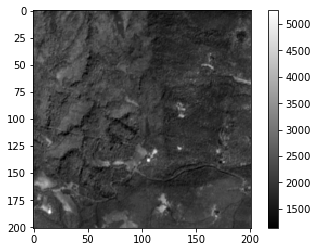

In [57]:
plt.imshow(im_b8.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

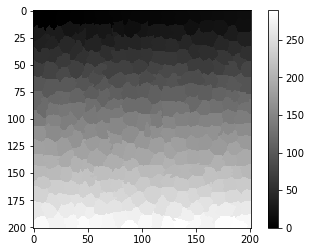

In [58]:
plt.imshow(segments.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [317]:
products[product]

{'title': 'S2B_MSIL1C_20200418T092029_N0209_R093_T35TKE_20200418T114821',
 'link': "https://scihub.copernicus.eu/dhus/odata/v1/Products('f1a06e84-ef56-4970-9ebb-14dd035d5988')/$value",
 'link_alternative': "https://scihub.copernicus.eu/dhus/odata/v1/Products('f1a06e84-ef56-4970-9ebb-14dd035d5988')/",
 'link_icon': "https://scihub.copernicus.eu/dhus/odata/v1/Products('f1a06e84-ef56-4970-9ebb-14dd035d5988')/Products('Quicklook')/$value",
 'summary': 'Date: 2020-04-18T09:20:29.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 362.41 MB',
 'ondemand': 'false',
 'datatakesensingstart': datetime.datetime(2020, 4, 18, 9, 20, 29, 24000),
 'beginposition': datetime.datetime(2020, 4, 18, 9, 20, 29, 24000),
 'endposition': datetime.datetime(2020, 4, 18, 9, 20, 29, 24000),
 'ingestiondate': datetime.datetime(2020, 4, 18, 18, 7, 51, 686000),
 'orbitnumber': 16278,
 'relativeorbitnumber': 93,
 'cloudcoverpercentage': 0.0,
 'sensoroperationalmode': 'INS-NOBS',
 'gmlfootprint': '<gml:Polygon srsName